In [1]:
from utils.utils import preprocess_watch_data
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation
from math import sin,cos
from numpy import random
import sys
from utils.utils import preprocess_watch_data
from utils.utils import get_yaw_pitch_roll
from utils.utils import get_rotation_matrix_from_yaw_pitch_roll
from utils.utils import get_rotated_basis
from utils.utils import get_rotation_matrix_to_rotate_vector_a_to_vector_b
from pytransform3d.rotations import extrinsic_euler_xyz_from_active_matrix,active_matrix_from_extrinsic_euler_xyz
import numpy as np
import pandas as pd
df = preprocess_watch_data("data/2022-01-24_19_34_26_Andrew’sAppleWatch.csv",save=False,plot=False)
df = df.fillna(method='ffill')

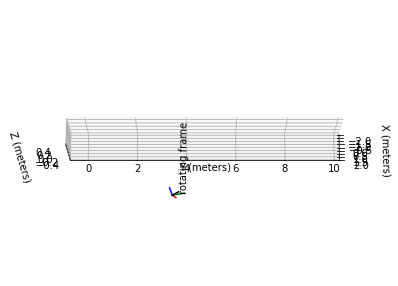

In [2]:
acc = np.array(df[['acc_x','acc_y','acc_z']])
omega = np.array(df[['gyr_x','gyr_y','gyr_z']])
time = df['gyr_t']
yaw_pitch_rolls = [np.zeros(3)]
Rs = [np.eye(3,3)]
R_tilts = [np.eye(3,3)]
bases = [np.eye(3,3)]
velocities = [np.zeros(3)]
positions = [np.zeros(3)]

for i,_ in enumerate(time):
    if (i==0):
        # don't have delta t, next
        continue
    delta_t = time[i]-time[i-1]
    yaw_pitch_roll = get_yaw_pitch_roll(i,omega,time,yaw_pitch_rolls)
    yaw_pitch_rolls.append(yaw_pitch_roll)
    R_tilt = get_rotation_matrix_to_rotate_vector_a_to_vector_b(acc[i])
    R = get_rotation_matrix_from_yaw_pitch_roll(*yaw_pitch_roll)
    Rs.append(R)
    R_tilts.append(R_tilt)
    R = R_tilt @ R
    acc_global = R @ acc[i]
    acc_global = acc_global + np.array([0,0,1])
    velocity = acc_global*delta_t + velocities[i-1]
    velocities.append(velocity)
    position = velocity*delta_t + positions[i-1]
    position[2] = 0
    # position = position*3
    positions.append(position)
    bases.append(get_rotated_basis(bases[0],R))

from utils.utils import animate_trajectory
animate_trajectory(time,bases,trajectory=positions)

# np.save('rpy.npy',np.array(yaw_pitch_rolls))
# np.save('pos.npy',np.array(positions))

In [3]:
acc = np.array(df[['acc_x','acc_y','acc_z']])
omega = np.array(df[['gyr_x','gyr_y','gyr_z']])
time = df['gyr_t']
yaw_pitch_rolls = [np.zeros(3)]
Rs = [np.eye(3,3)]
R_tilts = [np.eye(3,3)]
bases = [np.eye(3,3)]
velocities = [np.zeros(3),np.zeros(3)]
positions = [np.zeros(3),np.zeros(3)]

for i,_ in enumerate(time):
    # print(i)
    if (i==0):
    # don't have delta t, next
        continue
    # global last_t,last_ypr,last_velocity,last_position
    # t, omega,acc = process_line(f.readline(),device='watch')
    delta_t = time[i]-time[i-1]
    # print(delta_t)
    if(time[i]==0):
        continue
    # if(delta_t>1):
    #     last_t = t
    #     return
    # last_t = t

    yaw_pitch_roll = get_yaw_pitch_roll(i,omega,time,yaw_pitch_rolls)
    yaw_pitch_rolls.append(yaw_pitch_roll)
    R = get_rotation_matrix_from_yaw_pitch_roll(*yaw_pitch_roll)
    gravity_estimate = get_rotation_matrix_to_rotate_vector_a_to_vector_b(acc[i]) @ acc[i]
    motion_estimate = gravity_estimate - np.array([0,0,-1])
    if(np.isclose(acc[i][2],-1,atol=.004) and np.isclose(np.linalg.norm(omega[i]),0,atol=.004)):
        R_tilt = get_rotation_matrix_to_rotate_vector_a_to_vector_b(R.T[2],-np.array(acc[i]))
        R = R_tilt @ R
        yaw_pitch_rolls[-1] = extrinsic_euler_xyz_from_active_matrix(R,strict_check=False)
    for i,part in enumerate(motion_estimate):
        if(abs(part)<.004):
            motion_estimate[i] = 0
    motion_estimate[2] = 0
    # print(motion_estimate)
    velocity = motion_estimate*delta_t + velocities[i-1]
    velocities.append(velocity)
    position = velocity*delta_t + positions[i-1]
    positions.append(position)
    if(np.isclose(np.linalg.norm(acc),1,atol=.004)):
        velocities[-1] = np.zeros(3)

# from utils.utils import animate_trajectory
# animate_trajectory(time,bases,trajectory=None)

# np.save('rpy.npy',np.array(yaw_pitch_rolls))
# np.save('pos.npy',np.array(positions))

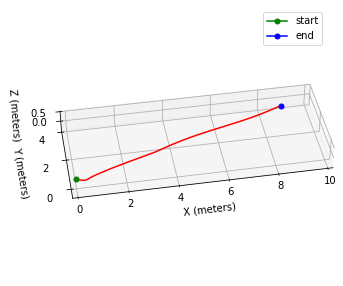

In [56]:
p = np.array(positions).T
t = np.arange(len(p.T))
x = p[0]
y = p[1]
z = p[2]
fig = plt.figure(figsize=(12, 5))

ax = fig.add_subplot(111, projection="3d",box_aspect=(10,4,1))
ax.set_xlim((0, 10))
ax.set_ylim((-.5, 4))
ax.set_zlim((-.5, .5))
ax.set_xlabel("X (meters)",labelpad=20)
ax.set_ylabel("Y (meters)")
ax.set_zlabel("Z (meters)")
ax.set_yticks([4,2,0])
ax.set_zticks([.5,0])
ax.view_init(elev=40., azim=260)
plt.plot(x,y,color='red')
plt.plot(x[0],y[0],marker='o',color='green',markersize=5,markerfacecolor='green',markeredgecolor='green',label='start')
plt.plot(x[-1],y[-1],marker='o',color='blue',markersize=5,markerfacecolor='blue',markeredgecolor='blue',label='end')

# plt.plot(y)
plt.legend()
plt.savefig("traj.pdf")
plt.savefig("traj.jpg",dpi=500)